# EDA Notes

A first attempt at EDA for the CS109 final project. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

**Read In Data**

In [2]:
checkins = pd.read_csv('Data/checkin_summary.csv', header=None)
photos = pd.read_csv('Data/photos_summary.csv', header=None)
reviews = pd.read_csv('Data/review_small.csv', header=None)
biz = pd.read_csv('Data/small_businesses.csv')
tips = pd.read_csv('Data/tip_summary.csv', header=None)
users = pd.read_json(path_or_buf='Data/user_small.json', lines=True)

/Users/maiawoluchem/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,10,12,14,20,63,64,74) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Explore data in its current state

In [4]:
checkins.shape, photos.shape, reviews.shape, biz.shape, tips.shape, users.shape

((49414, 2), (26384, 2), (2927859, 4), (38668, 93), (558979, 3), (1183362, 5))

In [5]:
checkins.columns = ['business_id', 'num_checkins'] 
checkins.head()

,business_id,num_checkins
0,--6MefnULPED_I942VcFNA,122
1,--9e1ONYQuAa-CB_Rrw7Tw,2469
2,--DaPTJW3-tB1vP-PfdTEg,88
3,--FBCX-N37CMYDfs790Bnw,477
4,--GM_ORV2cYS-h38DSaCLw,13


In [6]:
photos.columns = ['business_id', 'num_photos'] 
photos.head()

,business_id,num_photos
0,--6MefnULPED_I942VcFNA,1
1,--9e1ONYQuAa-CB_Rrw7Tw,127
2,--DaPTJW3-tB1vP-PfdTEg,1
3,--FBCX-N37CMYDfs790Bnw,4
4,--KCl2FvVQpvjzmZSPyviA,3


In [7]:
reviews.columns = ['user_id', 'business_id', 'rating', 'date'] 
reviews.head()

,user_id,business_id,rating,date
0,V2exkc2JwEdc8UNUNhT7sg,--6MefnULPED_I942VcFNA,5,2016-08-25
1,j97y1ZAsYABIOcR0KQCy5Q,--6MefnULPED_I942VcFNA,1,2010-12-06
2,8-KBKMJVO-j5YqpHb08j9w,--6MefnULPED_I942VcFNA,4,2015-08-05
3,CxDOIDnH8gp9KXzpBHJYXw,--6MefnULPED_I942VcFNA,2,2010-12-22
4,7Dykd1HolQx8mKPYhYDYSg,--6MefnULPED_I942VcFNA,2,2017-02-07


In [8]:
biz.columns=biz.columns.str.replace('attributes.','')
biz.columns=biz.columns.str.replace('.',"_")
biz.head()

,Ambience_divey,HairSpecializesIn_kids,RestaurantsDelivery,Open24Hours,Ambience_trendy,DogsAllowed,CoatCheck,postal_code,Smoking,DietaryRestrictions_halal,...,RestaurantsReservations,DietaryRestrictions_dairy-free,BestNights_wednesday,DietaryRestrictions_vegan,Ambience_romantic,Music_jukebox,Ambience_upscale,RestaurantsTakeOut,BikeParking,OutdoorSeating
0,False,NaN,False,NaN,False,NaN,False,28105,NaN,NaN,...,False,NaN,NaN,NaN,False,False,False,True,True,False
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28164,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,True,NaN,False,NaN,False,NaN,NaN,15224,NaN,NaN,...,False,NaN,NaN,NaN,False,NaN,False,True,True,False
3,NaN,NaN,False,NaN,NaN,NaN,NaN,L5W 0E6,NaN,NaN,...,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,True
4,False,NaN,False,NaN,False,NaN,NaN,53704,NaN,NaN,...,True,NaN,NaN,NaN,False,NaN,False,True,True,False


In [9]:
#Merge reviews and business for only the businesses in each set
full_biz = pd.merge(reviews, biz, on='business_id', how='inner')

In [10]:
full_biz.shape, reviews.shape, biz.shape

#Caused a drop of 2927859 - 2531183

((2531183, 96), (2927859, 4), (38668, 93))

In [11]:
#Drop where more than 50 percent missing
full_biz = full_biz.dropna(thresh=len(full_biz) - 1265591, axis=1)
full_biz.shape

(2531183, 52)

Ok here's what we have so far:

- Merged reviews and businesses together to make a dataset that includes ratings and business data
- Dropped the values that are missing at more than 50 percent, caused us to drop 44 variables. 
- At this point, we're at shape 2531183 x 52

In [12]:
#Create list of variable types so we can continue cleaning. 

binary_vars = ["Caters","RestaurantsReservations","Ambience_romantic","Ambience_upscale",
               "RestaurantsTakeOut","BikeParking","OutdoorSeating","BusinessParking_lot","HasTV","GoodForMeal_dinner",
               "BusinessParking_street","GoodForMeal_breakfast","BusinessParking_garage","BusinessParking_valet",
               "WheelchairAccessible","Ambience_intimate","Ambience_hipster","BusinessAcceptsCreditCards",
               "GoodForMeal_brunch","Ambience_classy","RestaurantsTableService","GoodForMeal_latenight",
               "GoodForMeal_dessert","Ambience_touristy","BusinessParking_validated","GoodForMeal_lunch",
               "RestaurantsGoodForGroups","GoodForKids","Ambience_casual","Ambience_divey","RestaurantsDelivery",
               "Ambience_trendy"]

text_vars = ["user_id","business_id","postal_code","city","categories",
             "name","neighborhood","state"]

float_vars = ["latitude","longitude","is_open","rating","stars","review_count","RestaurantsPriceRange2"]

cat_vars = ["Alcohol","WiFi","NoiseLevel","RestaurantsAttire"]

date_vars = ['date']

In [13]:
#Check to make sure we have everything!

len(binary_vars)+len(text_vars)+len(float_vars)+len(cat_vars)+len(date_vars)

52

In [14]:
#Create datasets that contain just the datatypes we want, as the correct datatypes. 

for var in binary_vars:
    full_biz[var] = 1*full_biz[var]
    
binary_df = full_biz[binary_vars].replace(np.nan, np.nan, regex=True)

for var in text_vars:
    full_biz[var] = full_biz[var].replace(np.nan, '', regex=True)
    full_biz[var] = full_biz[var].astype(str)
    
text_df = full_biz[text_vars]

for var in cat_vars:
    full_biz[var] = full_biz[var].replace(np.nan, '', regex=True)
    full_biz[var] = full_biz[var].astype(str)
    
cat_df = full_biz[cat_vars]

for var in date_vars:
    full_biz[var] = full_biz[var].replace(np.nan, '', regex=True)
    full_biz[var] = full_biz[var].astype(str)
    
date_df = full_biz[date_vars]

for var in float_vars:
    full_biz[var] = 1*full_biz[var]
    
float_df = full_biz[float_vars].replace(np.nan, np.nan, regex=True)

In [15]:
full_biz2 = binary_df.join(text_df)
full_biz2 = full_biz2.join(float_df)
full_biz2 = full_biz2.join(cat_df)
full_biz2 = full_biz2.join(date_df)

In [24]:
count_states = full_biz2.groupby('state').is_open.sum().sort_values()
count_states

state
ZET         3
ABE         3
WHT         4
CA          4
HH          4
3           5
XGL         6
RCC         7
KHL         7
ESX         8
BY         10
ST         24
PKN        24
01         24
WA         39
NI         47
NY         70
WLN        77
ELN        96
NYK       101
FIF       104
C         168
HLD       564
MLN       963
SC       4975
IL      18949
EDH     20119
BW      22097
WI      59810
QC      88812
PA     125869
OH     137516
NC     158907
ON     354382
AZ     716955
NV     820430
Name: is_open, dtype: int64

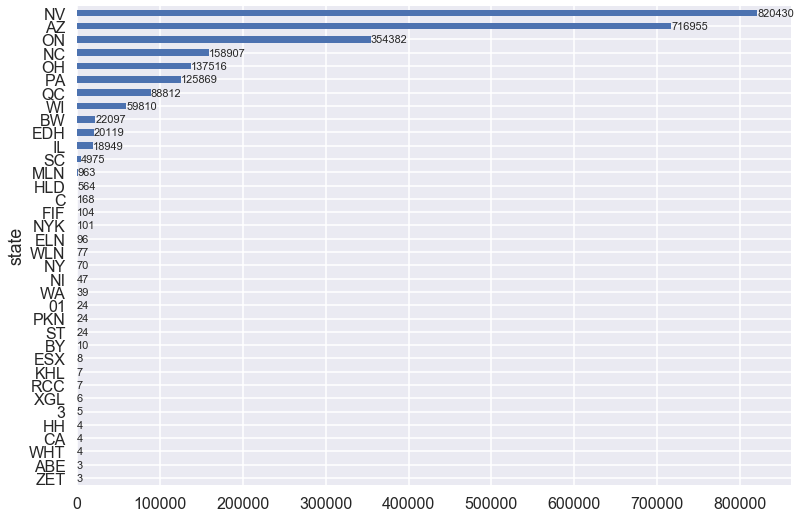

In [25]:
import seaborn as sns

with sns.plotting_context("poster"):
    ax = plt.gca()
    count_states.plot(kind="barh")
    plt.grid(axis = 'x', color ='white', linestyle='-')
    ax.tick_params(axis='both', which='both',length=0)
    states = count_states.index
    counts = count_states.values
    nums = np.arange(len(count_states))
    for p, c, ch in zip(nums, states, counts):
        plt.annotate(str(ch), xy=(ch + 1, p), va='center', size=11)
    sns.despine(left=True, bottom=True)

In [27]:
#Select NV, AZ, ON, NC, OH, PA, QC, WI, BW

states = ['NV','AZ','ON','NC','OH','PA','QC','WI','BW']
#full_biz2 = 
geo_subset_biz = full_biz2[full_biz2['state'].isin(['NV','AZ','ON','NC','OH','PA','QC','WI','BW'])]
#df[df['A'].isin([3, 6])]

In [28]:
count_states2 = geo_subset_biz.groupby('state').is_open.sum().sort_values()
count_states2

state
BW     22097
WI     59810
QC     88812
PA    125869
OH    137516
NC    158907
ON    354382
AZ    716955
NV    820430
Name: is_open, dtype: int64

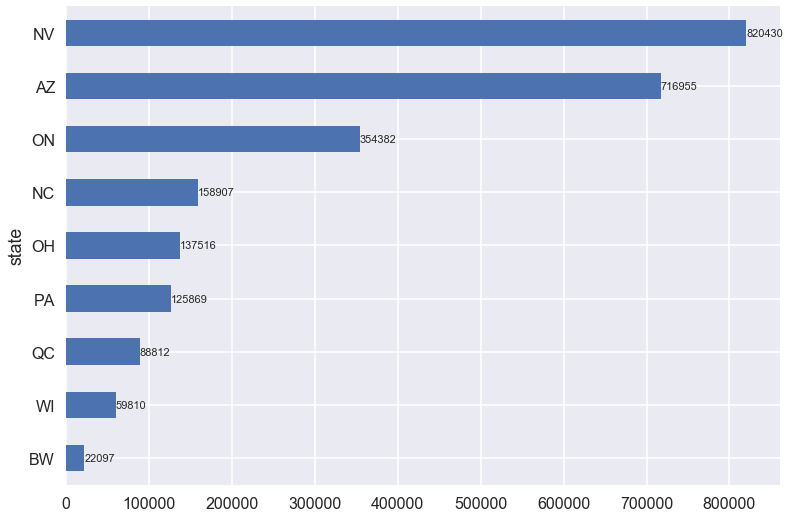

In [29]:
import seaborn as sns

with sns.plotting_context("poster"):
    ax = plt.gca()
    count_states2.plot(kind="barh")
    plt.grid(axis = 'x', color ='white', linestyle='-')
    ax.tick_params(axis='both', which='both',length=0)
    states = count_states2.index
    counts = count_states2.values
    nums = np.arange(len(count_states))
    for p, c, ch in zip(nums, states, counts):
        plt.annotate(str(ch), xy=(ch + 1, p), va='center', size=11)
    sns.despine(left=True, bottom=True)

In [30]:
geo_subset_biz.head()
geo_subset_biz.shape

(2484778, 52)

In [31]:
geo_subset_biz.shape
geo_subset_biz.categories=geo_subset_biz.categories.str.replace('[',"")
geo_subset_biz.categories=geo_subset_biz.categories.str.replace(']',"")
geo_subset_biz.categories=geo_subset_biz.categories.str.replace("'","")
#biz.columns=biz.columns.str.replace('[',"")
geo_subset_biz.categories.unique()
len(geo_subset_biz.categories.unique())

/Users/maiawoluchem/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:2999: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


18557

In [32]:
uniques = list(geo_subset_biz.categories.unique())
newlist = []
for word in uniques:
    word = word.split(",")
    #word = word.replace(' ','')
    newlist.extend(word)  # <----

newlist = [x.strip(' ') for x in newlist]

newlist


['Restaurants',
 'Chinese',
 'Steakhouses',
 'Cajun/Creole',
 'Restaurants',
 'Restaurants',
 'Breakfast & Brunch',
 'Food',
 'Beer',
 'Wine & Spirits',
 'Bars',
 'Restaurants',
 'American (New)',
 'Nightlife',
 'Salad',
 'Restaurants',
 'Chicken Wings',
 'Pizza',
 'Restaurants',
 'Sports Bars',
 'Nightlife',
 'Bars',
 'American (Traditional)',
 'Sandwiches',
 'Pizza',
 'Restaurants',
 'Chicken Wings',
 'Fast Food',
 'Restaurants',
 'Diners',
 'American (Traditional)',
 'Breakfast & Brunch',
 'Restaurants',
 'Chinese',
 'Restaurants',
 'Restaurants',
 'Pizza',
 'Restaurants',
 'Peruvian',
 'Spanish',
 'Latin American',
 'Restaurants',
 'Italian',
 'German',
 'Restaurants',
 'Sports Bars',
 'Nightlife',
 'Bars',
 'American (New)',
 'Sandwiches',
 'American (Traditional)',
 'Sports Bars',
 'Bars',
 'Nightlife',
 'Restaurants',
 'Restaurants',
 'Pizza',
 'Chicken Wings',
 'Italian',
 'Asian Fusion',
 'Restaurants',
 'Pizza',
 'Restaurants',
 'Bars',
 'Southern',
 'Restaurants',
 'Nightlif

In [33]:
df = pd.value_counts(newlist).to_frame().reset_index()
df

,index,0
0,Restaurants,18546
1,Food,6546
2,Nightlife,4702
3,Bars,4538
4,American (Traditional),3129
5,Sandwiches,2895
6,Breakfast & Brunch,2434
7,American (New),2130
8,Burgers,1693
9,Pizza,1690


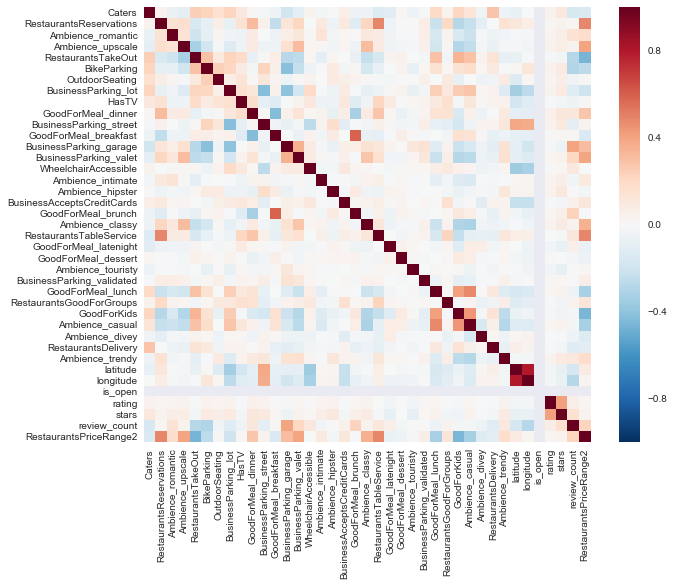

In [34]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize =(10,8))
sns.heatmap(geo_subset_biz.corr(), ax=ax)

In [ ]:
#dropping based on collinearity

#We have relatively few collinear points although we do have quite a few missing values - this is something 
#we'll discover soon enough in later EDA. 


In [36]:
goodfor_list = ['GoodForKids','GoodForMeal_breakfast','GoodForMeal_brunch','GoodForMeal_dessert','GoodForMeal_dinner',
               'GoodForMeal_latenight','GoodForMeal_lunch']

geo_subset_biz.GoodForKids.unique()

array([  1.,   0.,  nan])

In [138]:
#

In [136]:
def plot_relevant_question(dataframe, ax, criteria_label, title_to_use, boolean_query=True):
    df = dataframe.copy()
    
    if boolean_query:
        df = df.loc[df[criteria_label] == 1.0]
        plt.xlabel("rating")
        #fig.title(title_to_use, fontsize=24)
        #plt.hist(df.rating, ax=ax, color=sns.color_palette()[5], alpha=0.75, align='mid')
        df['rating'].plot(kind='hist', ax=ax, alpha=0.3, title=title_to_use,fontsize=22 )
        #plt.title(title_to_use, fontsize = 24)
        #df['rating'].plot(kind='hist', ax=ax, alpha=0.3, title=title_to_use, fontsize=24 )
        ax.set_ylim(0,600000)
        ax.set_title(title_to_use, fontsize=24)
        ax.set_xlabel("rating", fontsize=20)
        ax.set_ylabel("frequency", fontsize=20)
        #ax.xlabel("rating")
        #ax.title(fontsize=24)
        #ax.legend(loc='best')
        
    """else:
        for i, (g, group) in enumerate(df.groupby(criteria_label)):
            group['count'].plot(kind='hist', ax=ax[i], bins=10, alpha=0.3)
            ax[i].set_title(labels_to_use[i])
            ax[i].set_xlim(0,9000)"""

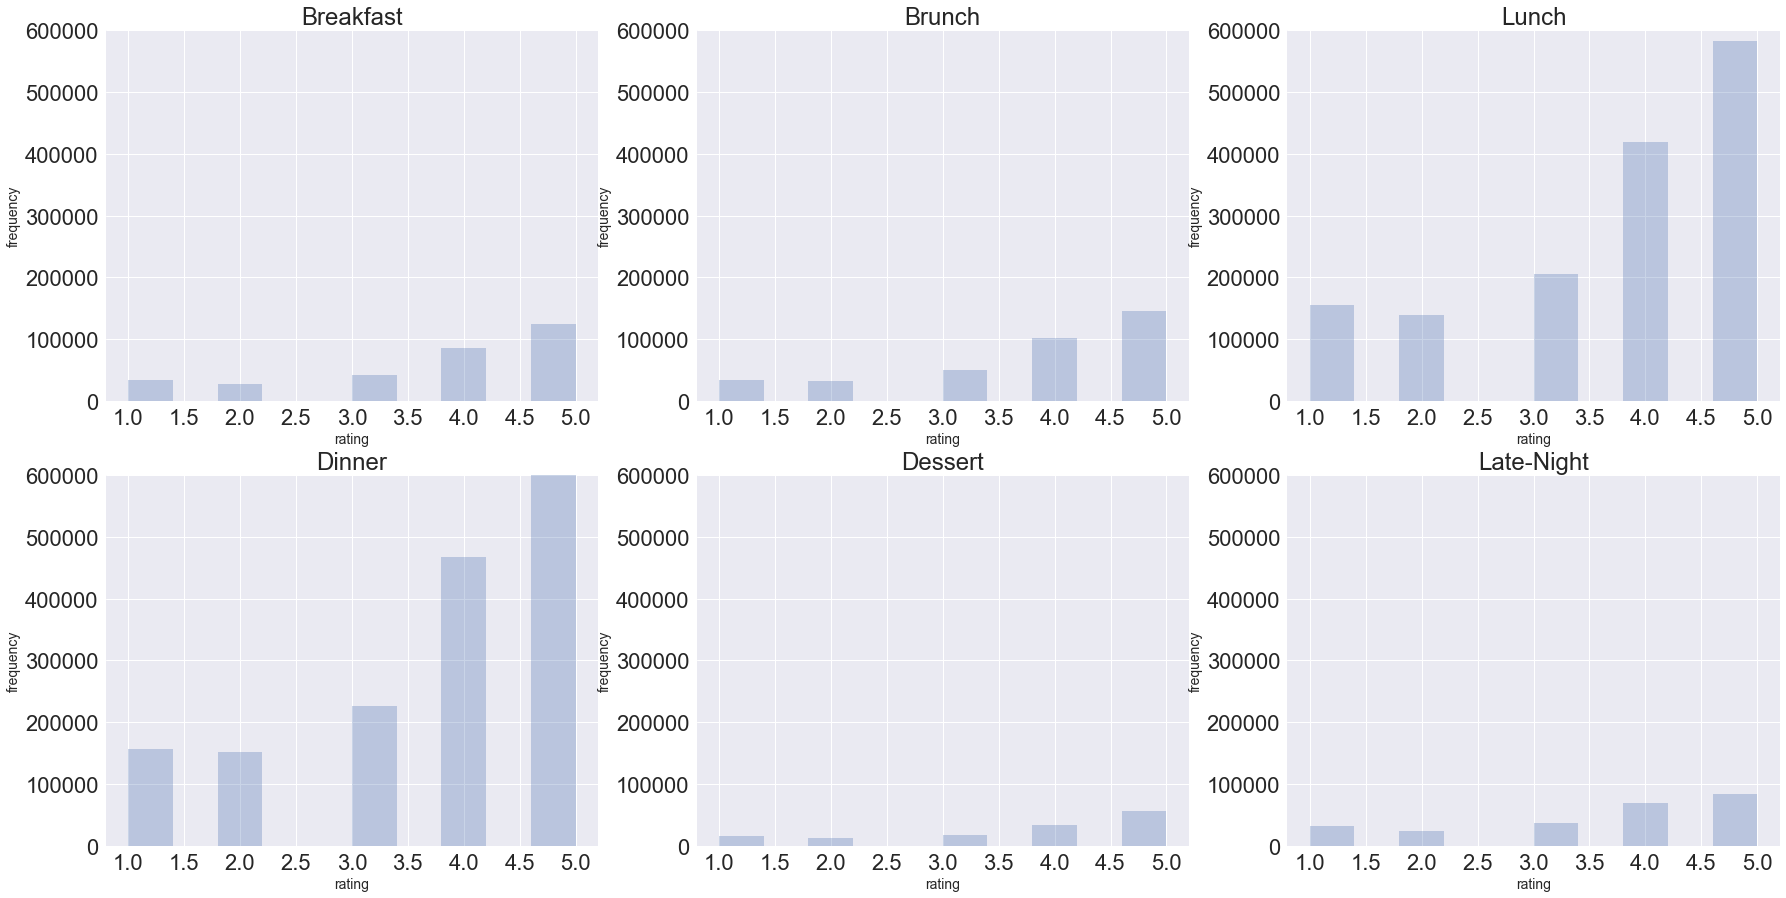

In [137]:
fig, ax = plt.subplots(2,3,figsize=(30,15))
#ax.set_ylim([0,600000])
ax = ax.flatten()



plot_relevant_question(geo_subset_biz, ax[0],'GoodForMeal_breakfast', 'Breakfast')
plot_relevant_question(geo_subset_biz, ax[1],'GoodForMeal_brunch', 'Brunch')
plot_relevant_question(geo_subset_biz, ax[2], 'GoodForMeal_lunch', 'Lunch')
plot_relevant_question(geo_subset_biz, ax[3], 'GoodForMeal_dinner', 'Dinner')
plot_relevant_question(geo_subset_biz, ax[4], 'GoodForMeal_dessert', 'Dessert')
plot_relevant_question(geo_subset_biz, ax[5], 'GoodForMeal_latenight', 'Late-Night')


plt.show()

In [ ]:
tips.columns = ['business_id', 'user_id', 'unidentifiedinfo_tips'] 

tips['business_id'] = tips['business_id'].map(lambda x: x[1:])
tips['user_id'] = tips['user_id'].map(lambda x: x[:-1])
tips.head()

In [ ]:
users.head()

In [ ]:
"""
Based on this knowledge, the following EDA steps may be necessary:

1. Label column headers - 
    a. Check-ins: User_ID, # of Check-ins
    b. Photos: User_ID, # of Photos
    c. Review: Business_ID?, User_ID?, Stars, Date (of the review?)
    d. Biz: Use column headers from dataset
    e. Tips: Business_ID, User_ID, # of tips?
    
    Questions that arise:
    - We have a wide range in the number of records across sets. Is it because 
    of the number of businesses, number of users, or both? We should confirm
    the population of each set and make sure we're clear on that in this EDA.
    
2. Merge variables as needed - 
    a. It may be easiest to work with one large dataset that is at the user-level
    that contains all of the information that we need. If so, the following pieces
    may be necessary:
    b. Determine what level we should be working at - user, review, or business
        i. Seems like we should be at the user-level, in which case, will we have 
        multiple duplicates for the users depending on how many reviews we have?
    c. Merge depending on level determined.
    
    Questions that arise:
    - 
    
3. Basic cleaning - 
    a. Do we have duplicates in any of these datasets? If so, why?
    b. Missing values - 
        i. Due to that merging, we should have missing values in some users
        ii. Figure out a strategy for dealing with those missing values. 
    
4. Do basic EDA - 

    a. How many unique users? Businesses? Reviews? 
    b. User behavior - 
        i. What do the most and least active users look like? Are they enthusiastic?
            Do they travel? 
        ii. Do a user's reviews tend to favor a particular style of restaurant 
            (is there a clustering of taste inherent in the data already)?
        iii. What do reviews look like? Are there certain variables that are 
            are always missing? 
    
    Questions that arise:
        - Do we have enough information about folks to adequately make these predictions?
            What else might we need to impute?
            
